# Part I: *Data Analysis and Preprocessing*

## A. Data Manipulation

#### a. Import, visualize, and save the contents of a dataset.

##### *algerian soil props*

In [1]:
import pandas as pd
import numpy as np
import io

df = pd.read_excel('../Data/soil_dz_allprops.xlsx')

# buffer = io.StringIO()
# df.info(show_counts=True, verbose=True, buf=buffer)
df.info(show_counts=True, verbose=True)
# s = buffer.getvalue()
# with open('./files/soil_dz_attributs_infos.txt', 'w') as f:
#     f.write(s)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CNT_FULLNAME      295 non-null    object 
 1   sand % topsoil    295 non-null    float64
 2   sand % subsoil    295 non-null    float64
 3   silt % topsoil    295 non-null    float64
 4   silt% subsoil     295 non-null    float64
 5   clay % topsoil    295 non-null    float64
 6   clay % subsoil    295 non-null    float64
 7   pH water topsoil  295 non-null    float64
 8   pH water subsoil  295 non-null    float64
 9   OC % topsoil      295 non-null    float64
 10  OC % subsoil      295 non-null    float64
 11  N % topsoil       295 non-null    float64
 12  N % subsoil       295 non-null    float64
 13  BS % topsoil      295 non-null    float64
 14  BS % subsoil      295 non-null    float64
 15  CEC topsoil       295 non-null    float64
 16  CEC subsoil       295 non-null    float64
 1

In [2]:
pd.set_option('display.max_columns', None)
df_no_geometry = df.drop('geometry', axis=1) 
df_no_geometry.head()

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,N % topsoil,N % subsoil,BS % topsoil,BS % subsoil,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,ALGERIA,49.57,43.09,28.200,24.200,22.230,32.710,5.86,5.39,2.4110,0.7420,0.1150,0.061,72.5,63.2,6.89,12.420,21.50,35.8,0.030,0.090,1.78,1.78,20.8,12.1
1,ALGERIA,56.97,55.06,21.440,19.190,21.690,25.680,5.92,6.02,1.0460,0.5500,0.1150,0.071,81.0,81.7,15.00,17.380,66.50,61.4,0.760,0.830,1.19,1.32,9.7,8.0
2,ALGERIA,57.39,55.21,24.315,22.825,18.295,21.965,6.27,5.75,1.2295,0.3905,0.0565,0.028,69.9,53.5,8.08,8.325,20.45,26.1,0.035,0.035,1.69,1.69,18.7,13.0
3,ALGERIA,20.41,24.08,32.930,29.190,46.620,46.690,7.86,8.03,0.6790,0.3820,0.0870,0.048,98.6,99.3,39.48,37.910,74.20,71.0,6.330,6.770,1.54,1.58,9.3,9.6
4,ALGERIA,31.42,28.46,21.650,20.520,46.890,50.950,7.32,7.49,0.6190,0.4240,0.0870,0.057,92.9,93.6,36.42,36.980,72.10,69.8,1.950,2.720,1.54,1.67,9.0,8.7


##### *wilayas' polygons data*

<class 'shapely.geometry.polygon.Polygon'>


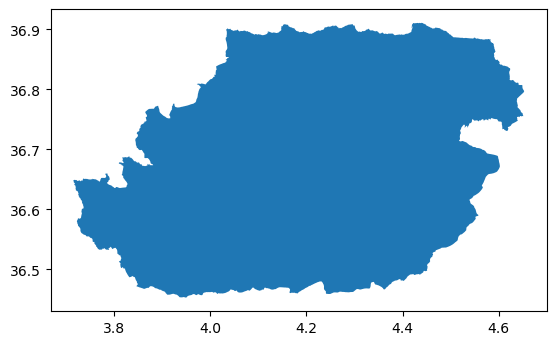

In [19]:
import geopandas as geopd

geodf = geopd.read_file(filename='../Data/wilayas/all-wilayas.shp')

geodf = geodf.drop(['name_ar', 'name_ber'], axis=1)
geodf.head(58)

tizi = geodf.loc[geodf['name'] == 'Tizi Ouzou']
tizi.head()

geo_tizi = tizi['geometry'].iloc[0]

tizi.plot()

print(type(geo_tizi))

In [4]:
from shapely import wkt

def safe_wkt_loads(wkt_str):
    try:
        return wkt.loads(wkt_str)
    except Exception as e:
        print(f"Error parsing WKT: {wkt_str} -> {e}")
        return None  # Return None for entries that fail

df['geometry'] = df['geometry'].apply(safe_wkt_loads)


df.dropna(subset=['geometry'], how='all', inplace=True)



Error parsing WKT: POLYGON ((5.980269908905029 34.56650161743164, 5.9806599617004395 34.56270980834961, 5.991310119628906 34.5434684753418, 6.001669883728027 34.49327850341797, 5.9951300621032715 34.47127151489258, 5.9852800369262695 34.43404006958008, 5.977729797363281 34.39255905151367, 5.988339900970459 34.250099182128906, 5.987060070037842 34.188560485839844, 5.983059883117676 34.18827819824219, 5.943850040435791 34.137428283691406, 5.88778018951416 34.12255859375, 5.782830238342285 34.107120513916016, 5.748340129852295 34.08375930786133, 5.702169895172119 34.02193832397461, 5.685259819030762 33.98979187011719, 5.6882100105285645 33.96617889404297, 5.7263898849487305 33.88452911376953, 5.735680103302002 33.878028869628906, 5.75629997253418 33.804901123046875, 5.777070045471191 33.768680572509766, 5.784969806671143 33.74674987792969, 5.793479919433594 33.73598098754883, 5.8030500411987305 33.685630798339844, 5.797989845275879 33.661441802978516, 5.767859935760498 33.60118865966797, 

In [5]:
df = df[df['geometry'].apply(lambda x: geo_tizi.intersects(x))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 6 to 21
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CNT_FULLNAME      4 non-null      object 
 1   sand % topsoil    4 non-null      float64
 2   sand % subsoil    4 non-null      float64
 3   silt % topsoil    4 non-null      float64
 4   silt% subsoil     4 non-null      float64
 5   clay % topsoil    4 non-null      float64
 6   clay % subsoil    4 non-null      float64
 7   pH water topsoil  4 non-null      float64
 8   pH water subsoil  4 non-null      float64
 9   OC % topsoil      4 non-null      float64
 10  OC % subsoil      4 non-null      float64
 11  N % topsoil       4 non-null      float64
 12  N % subsoil       4 non-null      float64
 13  BS % topsoil      4 non-null      float64
 14  BS % subsoil      4 non-null      float64
 15  CEC topsoil       4 non-null      float64
 16  CEC subsoil       4 non-null      float64
 17  CEC c

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4 entries, 6 to 21
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   CNT_FULLNAME      4 non-null      object  
 1   sand % topsoil    4 non-null      float64 
 2   sand % subsoil    4 non-null      float64 
 3   silt % topsoil    4 non-null      float64 
 4   silt% subsoil     4 non-null      float64 
 5   clay % topsoil    4 non-null      float64 
 6   clay % subsoil    4 non-null      float64 
 7   pH water topsoil  4 non-null      float64 
 8   pH water subsoil  4 non-null      float64 
 9   OC % topsoil      4 non-null      float64 
 10  OC % subsoil      4 non-null      float64 
 11  N % topsoil       4 non-null      float64 
 12  N % subsoil       4 non-null      float64 
 13  BS % topsoil      4 non-null      float64 
 14  BS % subsoil      4 non-null      float64 
 15  CEC topsoil       4 non-null      float64 
 16  CEC subsoil       4 non-nu

<Axes: >

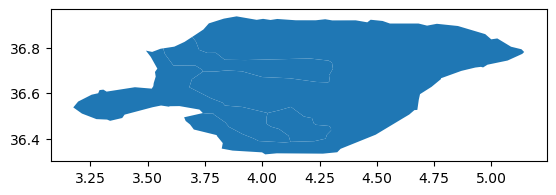

In [6]:
tizidf = geopd.GeoDataFrame(df, geometry='geometry')
tizidf.info()
tizidf.plot()

C:\Users\DropZone\AppData\Local\Temp\ipykernel_11288\3877691947.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


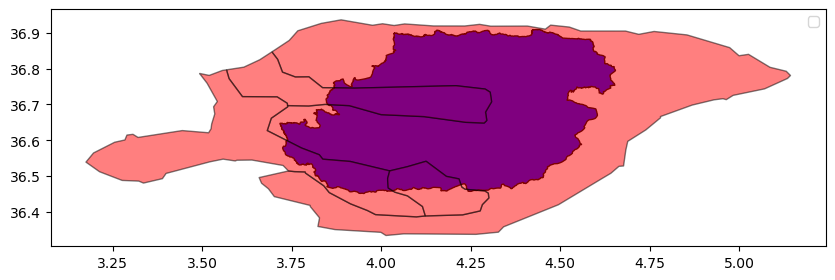

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# tizi de type geoDataFrame
tizi.plot(ax=ax, color="blue", edgecolor="black", label="geo_tizi")

# le df initiale avec que les données de la region de tizi ouzou
tizidf.plot(ax=ax, color="red", edgecolor="black", alpha=0.5, label="Intersecte")


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())


plt.show()

In [8]:
tizidf

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,N % topsoil,N % subsoil,BS % topsoil,BS % subsoil,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry
6,ALGERIA,55.90,54.180,20.240,19.38,23.880,26.440,6.94,7.28,0.6900,0.306,0.1320,0.048,86.2,94.2,12.06,12.14,47.6,42.8,2.020,5.100,1.42,1.500,10.8,8.4,"POLYGON ((3.69441 36.84677, 3.70489 36.85359, ..."
12,ALGERIA,40.08,38.085,20.015,18.79,39.875,43.095,6.89,7.02,0.6135,0.367,0.0795,0.046,89.6,90.6,27.37,29.37,61.0,63.9,0.845,1.245,1.46,1.595,10.4,9.7,"POLYGON ((3.56757 36.79656, 3.61600 36.80399, ..."
16,ALGERIA,55.44,54.550,20.840,19.55,23.750,25.900,6.94,7.36,0.6300,0.283,0.1430,0.058,90.6,95.5,12.71,13.13,45.7,46.4,2.980,7.440,1.47,1.500,10.7,8.2,"POLYGON ((3.49214 36.78658, 3.51923 36.78096, ..."
21,ALGERIA,59.20,61.050,15.650,15.30,25.200,23.650,7.30,7.70,0.8700,0.345,0.2100,0.060,80.5,94.5,13.20,10.25,50.0,36.5,4.900,12.300,1.30,1.500,10.5,6.0,"POLYGON ((4.12307 36.38830, 4.11507 36.41467, ..."


In [9]:
tizidf.to_csv('../Data/processedData/soil_dz_tizi.csv', index=False)

In [20]:
from netCDF4 import Dataset

import geopandas as geopd


In [ ]:
file_path = '../Data/Climate-DATA/PSurf_WFDE5_CRU_201901_v2.1.nc'
nc_data = Dataset(file_path, mode='r')
print(nc_data.variables.keys())
time_var = nc_data.variables['time'][:]
lon_var = nc_data.variables['lon'][:]
lat_var = nc_data.variables['lat'][:]
psurf_var = nc_data.variables['PSurf'][:]

psurf_flattened = psurf_var.reshape(len(time_var), -1).mean(axis=1)


# print(psurf_var)
psurf_df = geopd.GeoDataFrame({'time': time_var, 'PSurf': psurf_flattened})

psurf_df.info()

dict_keys(['time', 'lon', 'lat', 'PSurf'])
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: WATCH Forcing Data methodology applied to ERA5 data
    institution: Copernicus Climate Change Service
    contact: http://copernicus-support.ecmwf.int
    comment: Methodology implementation for ERA5 and dataset production by B-Open Solutions for the Copernicus Climate Change Service in the context of contract C3S_25c
    Conventions: CF-1.7
    summary: ERA5 data regridded to half degree regular lat-lon; Genuine land points from CRU grid and ERA5 land-sea mask only; PSurf elevation-corrected using Tair_WFDE5 and CRU TS4.04 v. ERA5 interpolated elevations
    reference: Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–2120, doi:10.5194/essd-12-2097-2020; Weedon et al., 2014, Water Resources Res., 50, 7505-7514, doi:10.1002/2014WR015638; Harris et al., 2020, Scientific Data, 7(1), doi:10.1038/s41597-020-0453-3
    licence: The dataset is distributed 

In [ ]:
dftizi = pd.read_csv('../Data/processedData/soil_dz_tizi.csv')

poly1= dftizi['geometry'][0]
poly2= dftizi['geometry'][1]
poly3= dftizi['geometry'][2]
poly4= dftizi['geometry'][3]

print(poly1)
print(poly2)
print(poly3)
print(poly4)

from shapely import bounds

print(bounds(wkt.loads(poly1)))
print(bounds(wkt.loads(poly2)))
print(bounds(wkt.loads(poly3)))
print(bounds(wkt.loads(poly4)))

all_bounds = [bounds(wkt.loads(poly1)),bounds(wkt.loads(poly2)),bounds(wkt.loads(poly3)),bounds(wkt.loads(poly4))]

print(all_bounds)

POLYGON ((3.694410085678101 36.84677124023438, 3.704890012741089 36.85358810424805, 3.742860078811646 36.87873840332031, 3.756089925765991 36.89361953735352, 3.766740083694458 36.90560150146484, 3.832329988479614 36.92631149291992, 3.883389949798584 36.93542861938477, 3.887769937515259 36.93621063232422, 3.975579977035522 36.92103958129883, 4.003459930419922 36.92528915405273, 4.035900115966797 36.92039108276367, 4.06525993347168 36.92481994628906, 4.145999908447266 36.91915893554688, 4.159379959106445 36.91915130615234, 4.233310222625732 36.9190788269043, 4.2746901512146 36.92361068725586, 4.305650234222412 36.91852951049805, 4.407949924468994 36.91888046264648, 4.458399772644043 36.91019058227539, 4.473130226135254 36.92142868041992, 4.525199890136719 36.91606903076172, 4.533440113067627 36.91318893432617, 4.557129859924316 36.90494155883789, 4.682119846343994 36.90489959716797, 4.719399929046631 36.8957405090332, 4.762119770050049 36.90370941162109, 4.854030132293701 36.894111633300

In [82]:
import xarray as xr
import os

# Define file paths
input_file = file_path
output_file = '../Data/processedData/poly1_sel2.nc'

def tizi_nc(input_file, output_file):

    # Open the NetCDF file with xarray
    ds = xr.open_dataset(input_file)


    subsets = []

    # Define longitude and latitude bounds
    for i, b in enumerate(all_bounds): 
        lon_min, lon_max = b[0], b[2]
        lat_min, lat_max = b[1], b[3]
    
        ds_subset = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))


        subsets.append(ds_subset)

    combined_ds = xr.concat(subsets, dim="polygon")

    combined_ds.to_netcdf(output_file)
    
    print(f"Combined dataset saved to {output_file}")

input_folder = '../Data/Climate-DATA/'
output_folder = '../Data/processedData/climate-data/'

os.makedirs(output_folder, exist_ok=True)

for name_file in os.listdir(input_folder):
    input_file_path = os.path.join(input_folder, name_file)

    if os.path.isfile(input_file_path) and name_file.endswith('.nc'):
        new_name_file = f"tizi_{name_file}"
        output_file_path = os.path.join(output_folder, new_name_file)

        tizi_nc(input_file_path, output_file_path)

Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201901_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201902_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201903_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201904_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201905_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201906_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201907_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201908_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201909_v2.1.nc
Combined dataset saved to ../Data/processedData/climate-data/tizi_PSurf_WFDE5_CRU_201910_v2.1.nc
Combined dataset saved to ../D

In [13]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray
from shapely.geometry import Polygon, mapping
from shapely.wkt import loads


In [14]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray
from shapely.geometry import Polygon, mapping
from shapely.wkt import loads
from typing import List
from pathlib import Path

def extract_psurf_for_regions(csv_file: str, netcdf_files: List[str]):
    """
    Extrait les données Psurf de plusieurs fichiers NetCDF pour chaque région 
    et les combine avec le CSV existant
    
    Parameters:
    -----------
    csv_file : str
        Chemin vers le fichier CSV contenant les données des régions
    netcdf_files : List[str]
        Liste des chemins vers les fichiers NetCDF contenant les données Psurf
    
    Returns:
    --------
    GeoDataFrame
        DataFrame contenant les données originales plus les moyennes Psurf
    """
    
    df = pd.read_csv(csv_file)
    
    df['geometry'] = df['geometry'].apply(loads)
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    all_psurf_means = {Path(f).stem: [] for f in netcdf_files}
    
    
    for nc_file in netcdf_files:
        file_name = Path(nc_file).stem
        print(f"\nTraitement du fichier: {file_name}")
        
        ds = xr.open_dataset(nc_file)
        
        # Vérification des noms des variables dans le dataset
        print("Variables disponibles:", list(ds.variables))
        
        # Utiliser le bon nom de variable (PSurf ou psurf)
        psurf_var = 'PSurf' if 'PSurf' in ds else 'psurf'
        psurf = ds[psurf_var]
        
        # Vérification des noms des dimensions
        print("Dimensions disponibles:", list(psurf.dims))
        
        # Utiliser les bons noms de dimensions pour longitude et latitude
        lon_name = 'lon' if 'lon' in psurf.dims else 'longitude'
        lat_name = 'lat' if 'lat' in psurf.dims else 'latitude'
        
        # ajouter les coordonnées spatiales au dataset
        psurf = psurf.rio.set_spatial_dims(x_dim=lon_name, y_dim=lat_name)
        psurf.rio.write_crs("EPSG:4326", inplace=True)
        
        #calcul de la moyenne Psurf pour chaque polygone
        for idx, row in gdf.iterrows():
            try:
                # clipper les données pour le polygone actuel
                clipped = psurf.rio.clip([mapping(row.geometry)], "EPSG:4326")
                # calculer la moyenne pour ce polygone
                mean_value = float(clipped.mean().values)
                all_psurf_means[file_name].append(mean_value)
            except Exception as e:
                print(f"Erreur pour l'index {idx} dans {file_name}: {e}")
                all_psurf_means[file_name].append(np.nan)
        
        ds.close()  

    for file_name, means in all_psurf_means.items():
        column_name = f'psurf_{file_name}'
        gdf[column_name] = means
    
    # calculer la moyenne globale sur tous les fichiers si nécessaire
    if len(netcdf_files) > 1:
        psurf_columns = [col for col in gdf.columns if col.startswith('psurf_')]
        gdf['psurf_mean'] = gdf[psurf_columns].mean(axis=1)
    
    # Sauvegarder le résultat
    output_file = 'soil_dz_tizi_with_psurf.csv'
    gdf.to_csv(output_file, index=False)
    
    return gdf

In [16]:
csv_file = '../Data/processedData/soil_dz_tizi.csv'

netcdf_files = ['../Data/Climate-DATA/PSurf_WFDE5_CRU_201901_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201902_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201903_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201904_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201905_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201906_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201907_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201908_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201909_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201910_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201911_v2.1.nc',
                '../Data/Climate-DATA/PSurf_WFDE5_CRU_201912_v2.1.nc'
                ]

result = extract_psurf_for_regions(csv_file, netcdf_files)
result.head()


Traitement du fichier: PSurf_WFDE5_CRU_201901_v2.1
Variables disponibles: ['time', 'lon', 'lat', 'PSurf']
Dimensions disponibles: ['time', 'lat', 'lon']
Erreur pour l'index 2 dans PSurf_WFDE5_CRU_201901_v2.1: No data found in bounds. Data variable: PSurf
Erreur pour l'index 3 dans PSurf_WFDE5_CRU_201901_v2.1: No data found in bounds. Data variable: PSurf

Traitement du fichier: PSurf_WFDE5_CRU_201902_v2.1
Variables disponibles: ['time', 'lon', 'lat', 'PSurf']
Dimensions disponibles: ['time', 'lat', 'lon']
Erreur pour l'index 2 dans PSurf_WFDE5_CRU_201902_v2.1: No data found in bounds. Data variable: PSurf
Erreur pour l'index 3 dans PSurf_WFDE5_CRU_201902_v2.1: No data found in bounds. Data variable: PSurf

Traitement du fichier: PSurf_WFDE5_CRU_201903_v2.1
Variables disponibles: ['time', 'lon', 'lat', 'PSurf']
Dimensions disponibles: ['time', 'lat', 'lon']
Erreur pour l'index 2 dans PSurf_WFDE5_CRU_201903_v2.1: No data found in bounds. Data variable: PSurf
Erreur pour l'index 3 dans P

,CNT_FULLNAME,sand % topsoil,sand % subsoil,silt % topsoil,silt% subsoil,clay % topsoil,clay % subsoil,pH water topsoil,pH water subsoil,OC % topsoil,OC % subsoil,N % topsoil,N % subsoil,BS % topsoil,BS % subsoil,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil,geometry,psurf_PSurf_WFDE5_CRU_201901_v2.1,psurf_PSurf_WFDE5_CRU_201902_v2.1,psurf_PSurf_WFDE5_CRU_201903_v2.1,psurf_PSurf_WFDE5_CRU_201904_v2.1,psurf_PSurf_WFDE5_CRU_201905_v2.1,psurf_PSurf_WFDE5_CRU_201906_v2.1,psurf_PSurf_WFDE5_CRU_201907_v2.1,psurf_PSurf_WFDE5_CRU_201908_v2.1,psurf_PSurf_WFDE5_CRU_201909_v2.1,psurf_PSurf_WFDE5_CRU_201910_v2.1,psurf_PSurf_WFDE5_CRU_201911_v2.1,psurf_PSurf_WFDE5_CRU_201912_v2.1,psurf_mean
0,ALGERIA,55.90,54.180,20.240,19.38,23.880,26.440,6.94,7.28,0.6900,0.306,0.1320,0.048,86.2,94.2,12.06,12.14,47.6,42.8,2.020,5.100,1.42,1.500,10.8,8.4,"POLYGON ((3.69441 36.84677, 3.70489 36.85359, ...",96650.046875,97215.476562,97010.218750,96198.3125,96397.117188,96367.187500,96311.945312,96458.921875,96643.281250,96614.648438,96119.101562,96794.921875,96565.098307
1,ALGERIA,40.08,38.085,20.015,18.79,39.875,43.095,6.89,7.02,0.6135,0.367,0.0795,0.046,89.6,90.6,27.37,29.37,61.0,63.9,0.845,1.245,1.46,1.595,10.4,9.7,"POLYGON ((3.56757 36.79656, 3.61600 36.80399, ...",99263.476562,99808.359375,99571.117188,98718.6250,98889.046875,98795.046875,98708.234375,98879.179688,99080.867188,99102.453125,98662.546875,99341.765625,99068.393229
2,ALGERIA,55.44,54.550,20.840,19.55,23.750,25.900,6.94,7.36,0.6300,0.283,0.1430,0.058,90.6,95.5,12.71,13.13,45.7,46.4,2.980,7.440,1.47,1.500,10.7,8.2,"POLYGON ((3.49214 36.78658, 3.51923 36.78096, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALGERIA,59.20,61.050,15.650,15.30,25.200,23.650,7.30,7.70,0.8700,0.345,0.2100,0.060,80.5,94.5,13.20,10.25,50.0,36.5,4.900,12.300,1.30,1.500,10.5,6.0,"POLYGON ((4.12307 36.38830, 4.11507 36.41467, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
file_path = '../Data/Climate-DATA/Qair_WFDE5_CRU_201901_v2.1.nc'
nc_data = Dataset(file_path, mode='r')
print(nc_data.dimensions.keys())
print(nc_data.variables.keys())
psurf_data = nc_data.variables['Qair'][:]
# psurf_data
print(type(psurf_data))

dict_keys(['time', 'lon', 'lat'])
dict_keys(['time', 'lon', 'lat', 'Qair'])
<class 'numpy.ma.core.MaskedArray'>


#### b. Provide a global description of the dataset.

#### c. Update/Delete an instance or value of the dataset.

## B. Analysis of characteristics 

#### a. Foreach attribute:

##### i. Calculate measures of central tendency and deduce symmetries

##### ii. Calculate measures of dispersion and deduce outliers

##### iii. Calculate the amount of missing values and unique values

##### iv. Construct boxplots and display outliers


##### v. Construct histograms and visualize the data distribution

#### b. Construct and display scatter plots of the data and deduce correlations

# INTERFACE

## C. Datareduction through aggregation by seasons

## D. Dataintegration: merges data from multiple sources into a single coherent dataset

## E. Multiple choices of handling outliers and missing values

## F. Datanormalization: Min-Max / z-score methods

## G. Datareduction via discretization of continuous data: Equal Frequency / Amplitude

## H. Datareduction (elimination of redundancies) horizontal / vertical